# For every pair from scraped data from MAL, determine if an anime is better than the other

In [113]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind_from_stats 
from scipy.stats import t as t_distribution
from itertools import combinations


## Read data

In [11]:
df = pd.read_csv('scores.csv').set_index('id')
df

,name,drop_ratio,std,mean,count
id,,,,,
32526,Sunshine S1,0.039016,1.671071,7.368589,77528
34973,Sunshine S2,0.024927,1.672406,7.584746,47058
37027,Sunshine Movie,0.006827,1.682756,7.639397,14204
15051,School Idol Project S1,0.034777,1.660956,7.397653,199156
19111,School Idol Project S2,0.018094,1.545763,7.784310,130882
24997,School Idol Project Movie,0.006421,1.568111,7.951345,63734
41169,Superstar,0.014702,1.653526,8.107192,5103
40879,Nijigasaki,0.035694,1.655863,7.562497,20057
10278,The iDOLM@STER,0.061465,1.614890,7.491589,49338


## Draw barplot of drop ratio

[Text(0.5, 0, 'Ratio (scale of 1)')]

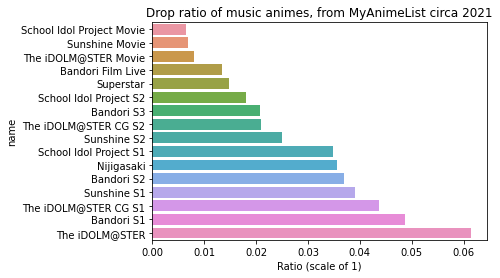

In [37]:
plt.title('Drop ratio of music animes, from MyAnimeList circa 2021')
ax = sns.barplot(data=df.sort_values('drop_ratio'), x='drop_ratio', y='name', orient='h')
ax.set(xlabel='Ratio (scale of 1)')

[Text(0.5, 0, 'Total viewers')]

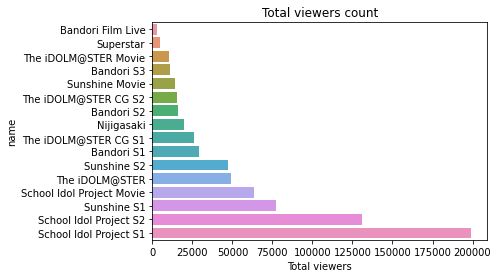

In [12]:
plt.title('Total viewers count')
ax = sns.barplot(data=df.sort_values('count'), x='count', y='name', orient='h')
ax.set(xlabel='Total viewers')

## Define mathematical functions

### Student's t-test  
Used when 2 samples have similar variance ($\frac{1}{2} < \frac{s_1}{s_2} < 2$).

t statistic:
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/faf70034d0a3a686080b98b32f64f2cc62a5dbad)

Where 
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/451cd1fdd5cb308af96957c3cb28131035b07e97)

Degrees of freedom: $n_1 + n_2 - 1$.

In [110]:
def student_ttest(mean1, mean2, std1, std2, n1, n2):
    '''
    Student's t-test: Calculate the `t` statistic of 2 independent samples with similar std (0.5 < s1/s2 < 2).
    '''
    if (std1 / std2 >= 2):
        print('Warning: s1/s2 > 2 in Student\'s t-test')
    sp = np.sqrt(((n1 - 1) * np.square(std1) + (n2 - 1) * np.square(std2)) / (n1 + n2 - 2))
    return (mean1 - mean2) / (sp * np.sqrt(1/n1 + 1/n2))

### Welch's t-test  
Used when 2 samples have unequal variances ($s_1 > 2s_2$ or $s_2 > 2s_1$)

t statistic: 

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/eeecf40c622f1fa6b0fb9462c7c4b7030cbb47eb)

Where

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/5024dd38e905d60353a324af2a05058fdd4ac3e7)

Degrees of freedom: 

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/bf9929fa7098ff7e57a5c421c0fdcb3eea20435f)

In [ ]:
def welch_ttest(mean1, mean2, std1, std2, n1, n2) -> float: 
    '''
    Welch's t-test: Calculate the `t` statistic of 2 independent samples with unequal std.
    Returns: `df`, `t`
    '''
    sqr = np.square 

    sn1 = sqr(std1) / n1 
    sn2 = sqr(std2) / n2
    
    # Degree of freedom 
    df_num = sqr(sn1 + sn2)
    df_denom = sn1 / (n1 - 1) + sn2 / (n2 - 1)
    df = df_num / df_denom

    sdelta = np.sqrt(sn1 + sn2)

    t = (mean1 - mean2) / sdelta

    return df, t

### One-tailed hypothesis testing

$$
\begin{cases} 
H_0: \mu_1 \ge \mu_2 \\
H_1: \mu_1 < \mu2
\end{cases}
$$

or 

$$
\begin{cases} 
H_0: \mu_1 \le \mu_2 \\
H_1: \mu_1 > \mu2
\end{cases}
$$

Steps:
- Calculate t statistics. 
- Calculate p-value using Student's t-distribution $t_{df, T}$.
- If $p < \alpha$, reject $H_0$. 

In [34]:
# Composite standard deviation
# http://www.burtonsys.com/climate/composite_standard_deviations.html#part2

def composite_stats(means, stds, counts):
    '''
    Calculate the grand mean and grand standard deviation (ANOVA) from multiple groups
    Returns: `gm`, `gv`
    '''
    # Grand mean (mean of means)
    GM = np.sum(np.multiply(counts, means)) / np.sum(counts)
    # Variance of each group
    Var = np.square(stds)
    # ESS of each group
    ESSG = np.multiply(Var, counts - 1)
    # ESS of the whole dataset
    ESS = np.sum(ESSG)
    
    GSS = np.multiply(np.square(means - GM), counts)
    TGSS = np.sum(GSS)
    # Grand variance 
    GV = (ESS + TGSS) / (np.sum(counts) - 1)
    return GM, np.sqrt(GV)


In [14]:
grp_animes = {
    "Love Live!": [15051, 24997, 19111],
    "Love Live! Sunshine!!": [32526, 34973, 37027],
    "Love Live! Nijigasaki": [40879], 
    "Love Live! Superstar!!": [41169], 
    'iM@S': [10278, 17437], 
    'iM@S CG': [30344, 23587],
    'Bandori': [33573, 37869, 37870, 39619]
}

In [38]:
grp_stats = []
for grp in grp_animes: 
    animes = df.loc[grp_animes[grp]]
    gm, gstd = composite_stats(animes['mean'], animes['std'], animes['count'])
    grp_stats.append({
        'group': grp, 
        'mean': gm, 
        'std': gstd, 
        'count': np.sum(animes['count'])
    })
grp_stats = pd.DataFrame(grp_stats).set_index('group')
grp_stats

,mean,std,count
group,,,
Love Live!,7.615788,1.624558,393772
Love Live! Sunshine!!,7.469594,1.676636,138790
Love Live! Nijigasaki,7.562497,1.655863,20057
Love Live! Superstar!!,8.107192,1.653526,5103
iM@S,7.514104,1.605226,59488
iM@S CG,7.222713,1.567322,41906
Bandori,7.359061,1.667971,59455


In [125]:
name1 = 'iM@S CG'
name2 = 'iM@S'

g1 = grp_stats.loc[name1]
g2 = grp_stats.loc[name2]

t, p = ttest_ind_from_stats(
    mean1=g1['mean'],
    mean2=g2['mean'], 
    std1=g1['std'], 
    std2=g2['std'], 
    nobs1=g1['count'], 
    nobs2=g2['count'], 
    alternative='less'
)
print(t, p)

-28.74191894839031 3.059004346320111e-181


In [134]:
pairs = list(combinations(grp_stats.index, 2))

test_results = []
alpha = 0.05
# H0: group1 >= group2
# H1: group1 < group2
for pair in pairs: 
    group1Name = pair[1]
    group2Name = pair[0]

    g1 = grp_stats.loc[group1Name]
    g2 = grp_stats.loc[group2Name]

    t = student_ttest(
        mean1=g1['mean'],
        mean2=g2['mean'], 
        std1=g1['std'], 
        std2=g2['std'], 
        n1=g1['count'], 
        n2=g2['count']
    )
    # cdf = P(t <= T): probability of H0 being rejected
    pvalue = t_distribution.cdf(x=t, df=g1['count'] + g2['count'] - 2)
    test_results.append({
        'group1': group1Name, 
        'group2': group2Name,
        'maybe better': pvalue >= alpha,    # false: reject H0
        'greater score': g1['mean'] >= g2['mean']
    })

In [135]:
test_results = pd.DataFrame(test_results)
test_results

,group1,group2,maybe better,greater score
0,Love Live! Sunshine!!,Love Live!,False,False
1,Love Live! Nijigasaki,Love Live!,False,False
2,Love Live! Superstar!!,Love Live!,True,True
3,iM@S,Love Live!,False,False
4,iM@S CG,Love Live!,False,False
5,Bandori,Love Live!,False,False
6,Love Live! Nijigasaki,Love Live! Sunshine!!,True,True
7,Love Live! Superstar!!,Love Live! Sunshine!!,True,True
8,iM@S,Love Live! Sunshine!!,True,True
9,iM@S CG,Love Live! Sunshine!!,False,False
